In [1]:
import json
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import training_scripts.domain.sampler as sampler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import math
import numpy as np
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
def load_data(directory):
    data_dicts = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            data_dict = json.load(f)
        data_dicts.append(data_dict)
    return data_dicts

In [3]:
def build_dataframe(data_dicts):
    return pd.json_normalize(data_dicts)


def reformat_dataframe(df, columns_to_keep):
    df = df.rename(columns_to_keep, axis=1)
    df = df[list(columns_to_keep.values())]
    return df

In [13]:
def drop_unlabeled_data(df, column):
    return df[(df[column] == True) | (df[column] == False)]

def balance_data(df, column):
    df_grouped = df.groupby(column)
    sample_size = df_grouped.size().min()

    def sample(df):
#         return df.sample(sample_size).reset_index(drop=True)
        return df.sample(sample_size)

    df_grouped_sampled = df_grouped.apply(sample)
    df_sampled = pd.DataFrame(df_grouped_sampled)
    df_sampled = df_sampled.droplevel(level=0)
    
#     df_sampled = df_sampled.sample(frac=.5) #added this line so that not all coronavirus stories end up in training set
    
    sampled_indeces = df_sampled.index.values
    df_not_sampled = df[~df.index.isin(sampled_indeces)]
    return (df_not_sampled, df_sampled)

In [5]:
def count_keywords(df, columns, keywords):
    for keyword in keywords:

        def count_keyword(string):
            return sum(
                keyword in word
                for word in string.lower().split())

        df[keyword] = df[columns].applymap(count_keyword).sum(axis=1)
    return df

In [6]:
def plot_confusion_matrices(classifiers, x,y,title,normalize=None, nrows = 1):
    ncols = math.ceil(len(classifiers)/nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(ncols*5,nrows*3.7))
    for cls, ax in zip(classifiers, axes.flatten()):
        plot_confusion_matrix(cls,
                      x, 
                      y,
                      ax=ax, 
                      cmap='Blues',
                      normalize = normalize,
                     display_labels=['Not COVID','COVID'])
        ax.title.set_text(type(cls).__name__)
    fig.suptitle(title, fontsize='xx-large',ha='left')
    plt.tight_layout()  
    plt.show()

In [7]:
def train_classifiers(classifiers, x,y, debug=False):
    for cls in classifiers:
        if debug: print(type(cls).__name__ + "... ",end="")
        cls.fit(x,y)
        if debug: print("done")

In [8]:
directory = '../data/news_articles/balanced_dataset/'
data = load_data(directory)

df_init = build_dataframe(data)

columns_to_keep = {
    'LABEL.WANT_ON_MAP': '_label',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title'}
df_init = reformat_dataframe(df_init, columns_to_keep)

column = '_label'
df_init = drop_unlabeled_data(df_init, column)

### RULE BASED MODEL WITH ML

In [9]:
def sample_tough_ones(df,pat,frac=.8):
    #sample toughest to classify set of stories:
    #ones without keywords in the title but with keywords in the article content
    
    tough_ones=df[(~(df['title'].str.contains(pat=pat, case=False,regex = True))) & df['text'].str.contains(pat=pat, case=False,regex = True)]
    df_sampled = tough_ones.sample(frac=frac)
    sampled_indeces = df_sampled.index.values
    df_not_sampled = tough_ones[~tough_ones.index.isin(sampled_indeces)]
    return (df_not_sampled, df_sampled)

In [288]:
# def predict_with_rules(_df, classifiers, pat,normalize=None, nrows = 1):
#     ncols = math.ceil(len(classifiers)/nrows)
#     fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(ncols*5,nrows*3.7))
#     for cls, ax in zip(classifiers, axes.flatten()):
#         predicted = cls.predict(_df[keywords]) | (_df['title'].str.contains(pat=pat, case=False,regex = True))
#         matrix = confusion_matrix(_df['label'].astype(bool),predicted, normalize=normalize)
#         display = ConfusionMatrixDisplay(matrix, display_labels=  ['Not COVID','COVID'])
#         display.plot(cmap="Blues",ax=ax)
#         ax.title.set_text(type(cls).__name__)
#     plt.tight_layout()  
#     plt.show()

In [11]:
columns = [
    'text',
    'title']
article_keywords = [
    'covid',
    'corona',
    'pandem',
    'epidem',
    'mask',
    'quarant',
    'vaccine',
]
# title_keywords =  'covid|corona|pandem|epidem|mask|quarant|vaccine|lockdown'
title_keywords =  "|".join(article_keywords)+"|lockdown"

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ]

# rows train: 266 (11.28% COVID)
# rows test: 66 (16.67% COVID)



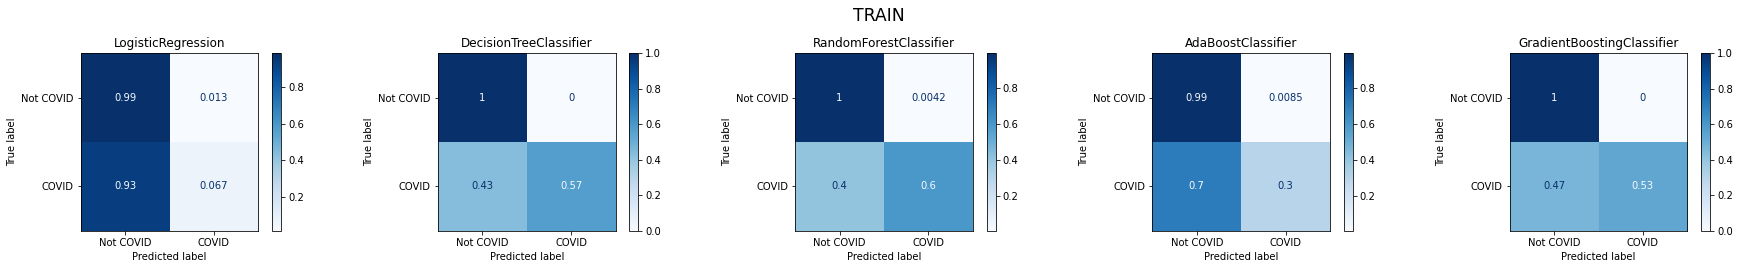

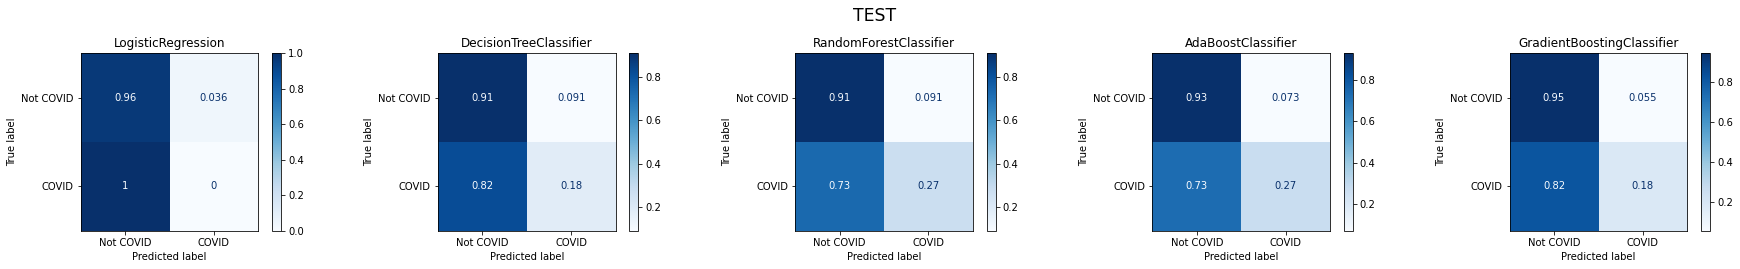

In [316]:
df = count_keywords(df_init, columns, article_keywords)
(test, train) = sample_tough_ones(df,title_keywords)

X_train = train[article_keywords]
X_test = test[article_keywords]
y_train = train[column].astype(bool)
y_test = test[column].astype(bool)

train_classifiers(classifiers,X_train, y_train)

print(f"# rows train: {train.shape[0]} ({100*(train[train[column] == True].shape[0]/train.shape[0]):.2f}% COVID)")
print(f"# rows test: {test.shape[0]} ({100*(test[test[column] == True].shape[0]/test.shape[0]):.2f}% COVID)")
print()
plot_confusion_matrices(classifiers, X_train, y_train,title="TRAIN", normalize='true')
print()
plot_confusion_matrices(classifiers, X_test, y_test,title="TEST", normalize='true')

### TF IDF VECTORIZE

In [260]:
def vectorize(df,tfidfvectorizer):
    train = df['text'] 
    # instantiate the vectorizer object
    # convert th documents into a matrix
    tfidf_wm = tfidfvectorizer.fit_transform(train)
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns =tfidf_tokens)
    return df_tfidfvect

In [261]:
def plot_test_train(model,test,train,label_column):
    dfs = [test,train]
    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10,3.7))
    plot_confusion_matrix(model, test.drop(label_column, axis = 1), test[label_column].astype(bool),normalize='true',ax=axes[0])
    axes[0].title.set_text("test")
    plot_confusion_matrix(model, train.drop(label_column, axis = 1), train[label_column].astype(bool),normalize='true',ax=axes[1])
    axes[1].title.set_text("train")
    plt.tight_layout()  
    plt.show()

### SINGLE MODEL WITH THRESHOLD

# rows train: 1582 (10.75% COVID)
# rows test: 1589 (10.70% COVID)



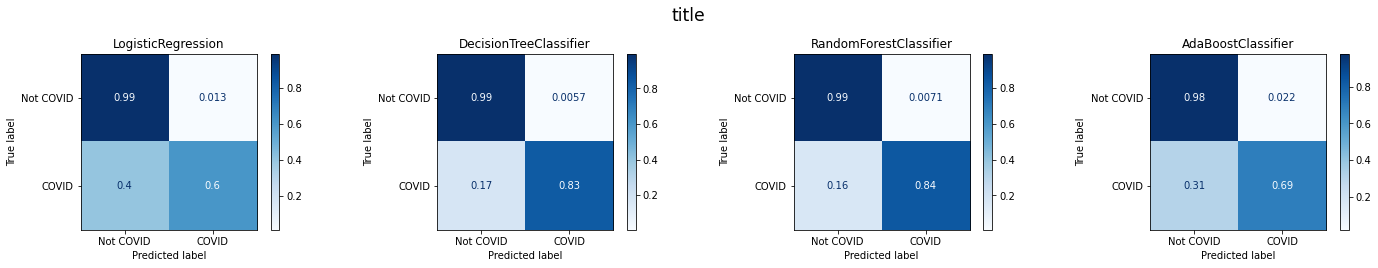

In [15]:
# df = count_keywords(df_init, columns, article_keywords)
# (test, train) = balance_data(df,columns)

# X_train = train[article_keywords]
# X_test = test[article_keywords]
# y_train = train[column].astype(bool)
# y_test = test[column].astype(bool)

# train_classifiers(classifiers,X_train, y_train)

# print(f"# rows train: {train.shape[0]} ({100*(train[train[column] == True].shape[0]/train.shape[0]):.2f}% COVID)")
# print(f"# rows test: {test.shape[0]} ({100*(test[test[column] == True].shape[0]/test.shape[0]):.2f}% COVID)")
# print()
# plot_confusion_matrices(classifiers, X_train, y_train,title="TRAIN", normalize='true')
# print()
# plot_confusion_matrices(classifiers, X_test, y_test,title="TEST", normalize='true')
columns = [
    'text',
    'title']
article_keywords = [
    'covid',
    'corona',
    'pandem',
    'epidem',
    'mask',
    'quarant',
]
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    ]

directory = '../data/news_articles/balanced_dataset/'
data = load_data(directory)

df = build_dataframe(data)

columns_to_keep = {
    'LABEL.WANT_ON_MAP': '_label',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title'}
column = '_label'

df = reformat_dataframe(df, columns_to_keep)
df = drop_unlabeled_data(df, column)
df = count_keywords(df, columns, article_keywords)

(test, train) = balance_data(df,columns)

train_classifiers(classifiers,train[article_keywords], train[column].astype(bool))

for cls in classifiers:
    cls.fit(train[article_keywords],train[column].astype(bool))

print(f"# rows train: {train.shape[0]} ({100*(train[train[column] == True].shape[0]/train.shape[0]):.2f}% COVID)")
print(f"# rows test: {test.shape[0]} ({100*(test[test[column] == True].shape[0]/test.shape[0]):.2f}% COVID)")
print()
plot_confusion_matrices(classifiers, train[article_keywords], train[column].astype(bool), title="title",normalize='true')


NameError: name 'keywords' is not defined

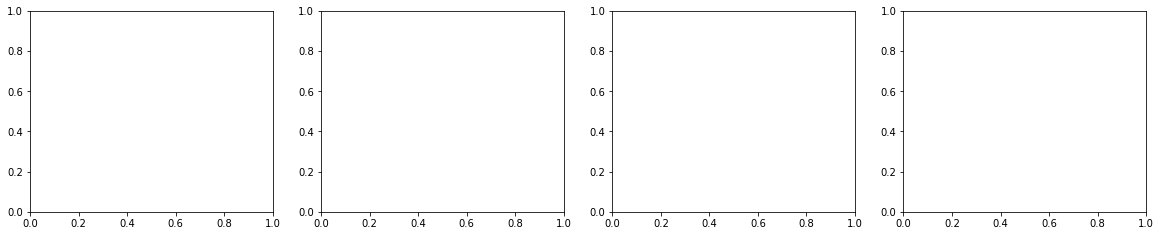

In [16]:
def predict_with_threshold(_df,classifiers,threshold,nrows=1,normalize=None):
    ncols = math.ceil(len(classifiers)/nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(ncols*5,nrows*3.7))
    for cls, ax in zip(classifiers, axes.flatten()):
        predicted = cls.predict_proba(_df[keywords])[:,1] > threshold
        matrix = confusion_matrix(_df['label'].astype(bool),predicted, normalize=normalize)
        display = ConfusionMatrixDisplay(matrix, display_labels=  ['Not COVID','COVID'])
        display.plot(cmap="Blues",ax=ax)
        ax.title.set_text(type(cls).__name__)
    plt.tight_layout()  
    plt.show()
predict_with_threshold(df,classifiers,threshold=.8,normalize='true')

### export model

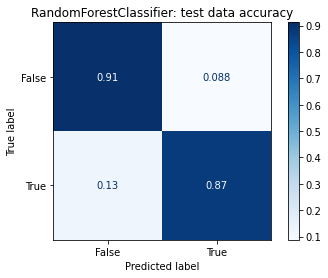

In [129]:
model=classifiers[2] 
# Save the model as a pickle in a file
name = '_.pkl'
joblib.dump(model, name)
  
# Load the model from the file
model_from_joblib = joblib.load(name) 

# display confusion matrix to double check everything is good
plot_confusion_matrix(model, test[keywords], test[column].astype(bool),normalize='true',cmap='Blues')
plt.title(f"{type(model).__name__}: test data accuracy")
plt.show()

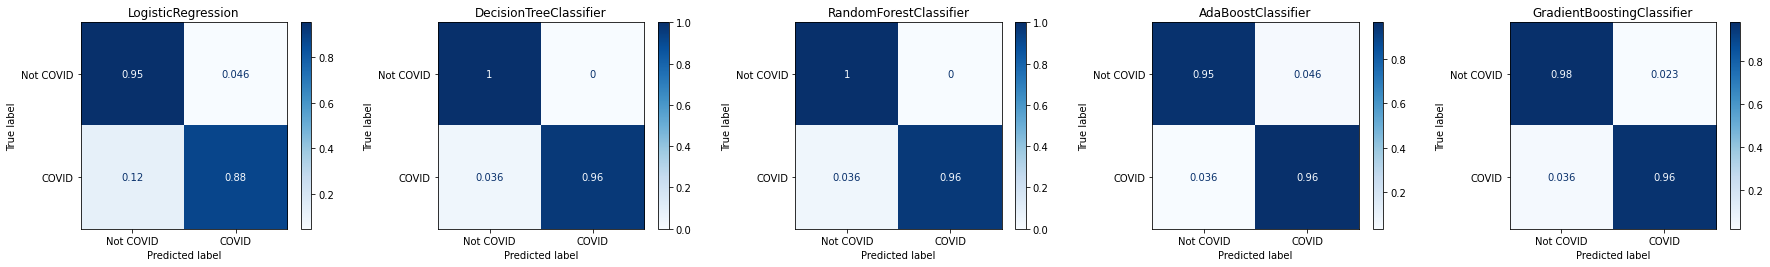

In [109]:
plot_confusion_matrices(classifiers, train[keywords], train[column].astype(bool), normalize='true')

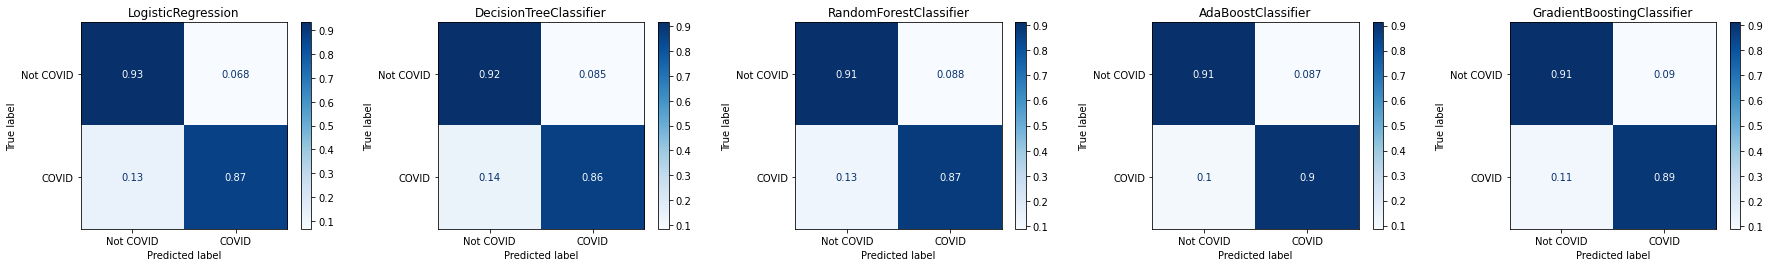

In [110]:
plot_confusion_matrices(classifiers, test[keywords], test[column].astype(bool),normalize='true')